In [1]:
!pip install -q catboost pandas scikit-learn joblib shap optuna wandb seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 27.0 MB/s eta 0:00:00


 Импорты и глобальные настройки


In [2]:

import os
import math
import time

import pandas as pd
import numpy as np

import joblib
import shap
import optuna
import wandb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.1)

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

# Пути и настройки
DATA_PATH = "case_hardened_knives.csv"

MODEL_CBM_PATH = "case_hardened_catboost_price_model.cbm"
WRAPPER_PKL_PATH = "case_hardened_catboost_wrapper.pkl"

TARGET = "price"
RANDOM_STATE = 42

# Числовые признаки
NUM_FEATURES = [
    "float", "pattern", "stattrak",
    "backside_blue", "backside_purple", "backside_gold",
    "playside_blue", "playside_purple", "playside_gold"
]

# Категориальные признаки (без market_hash_name!)
CAT_FEATURES = ["weapon", "skin", "wear"]

ALL_FEATURES = NUM_FEATURES + CAT_FEATURES


Загрузка датасета и базовый препроцессинг

In [3]:


if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Файл {DATA_PATH} не найден. "
        "Загрузи CSV в Colab (слева вкладка Files или через files.upload())."
    )

df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]

print("Размер датасета:", df.shape)
display(df.head())

required_cols = set(NUM_FEATURES + CAT_FEATURES + [TARGET])
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"В CSV нет колонок: {missing}")

# Берём только нужные колонки
df = df[list(required_cols)]

# удаляем строки без цены или без float
df = df.dropna(subset=[TARGET, "float"]).copy()

# числовые фичи: приводим к float и заполняем медианой
for col in NUM_FEATURES:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col] = df[col].fillna(df[col].median())

# категориальные фичи: строковый тип + "Unknown"
for col in CAT_FEATURES:
    df[col] = df[col].astype(str).fillna("Unknown")

print("\nПосле базовой очистки:")
print("Размер:", df.shape)
display(df.head())


Размер датасета: (9596, 28)


,weapon,skin,wear,float,pattern,stattrak,price,phase,backside_blue,backside_purple,...,stickers_total_over_price,slot0_name,slot0_price,slot1_name,slot1_price,slot2_name,slot2_price,slot3_name,slot3_price,market_hash_name
0,Karambit,Case Hardened,Factory New,0.012511,777,0,3791.90,NaN,0.02,0.82,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,★ Karambit | Case Hardened (Factory New)
1,Karambit,Case Hardened,Factory New,0.023469,777,0,3768.72,NaN,0.02,0.82,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,★ Karambit | Case Hardened (Factory New)
2,Karambit,Case Hardened,Factory New,0.026855,777,0,3866.74,NaN,0.02,0.82,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,★ Karambit | Case Hardened (Factory New)
3,Karambit,Case Hardened,Factory New,0.000000,777,0,3972.25,NaN,0.02,0.82,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,★ Karambit | Case Hardened (Factory New)
4,Karambit,Case Hardened,Factory New,0.056767,766,0,1900.78,NaN,2.72,5.43,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,★ Karambit | Case Hardened (Factory New)



После базовой очистки:
Размер: (9596, 13)


,pattern,price,wear,skin,playside_purple,stattrak,backside_blue,backside_purple,playside_gold,weapon,playside_blue,backside_gold,float
0,777,3791.90,Factory New,Case Hardened,16.61,0,0.02,0.82,50.91,Karambit,32.48,99.15,0.012511
1,777,3768.72,Factory New,Case Hardened,16.61,0,0.02,0.82,50.91,Karambit,32.48,99.15,0.023469
2,777,3866.74,Factory New,Case Hardened,16.61,0,0.02,0.82,50.91,Karambit,32.48,99.15,0.026855
3,777,3972.25,Factory New,Case Hardened,16.61,0,0.02,0.82,50.91,Karambit,32.48,99.15,0.000000
4,766,1900.78,Factory New,Case Hardened,11.31,0,2.72,5.43,31.81,Karambit,56.88,91.85,0.056767


#EDA

##  Распределение цен (Histogram + Boxplot)

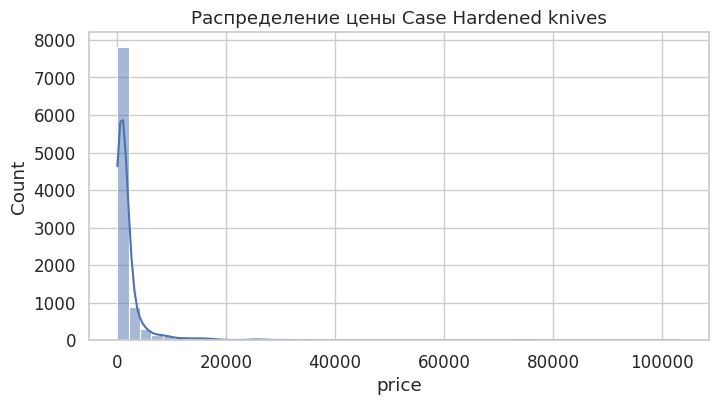

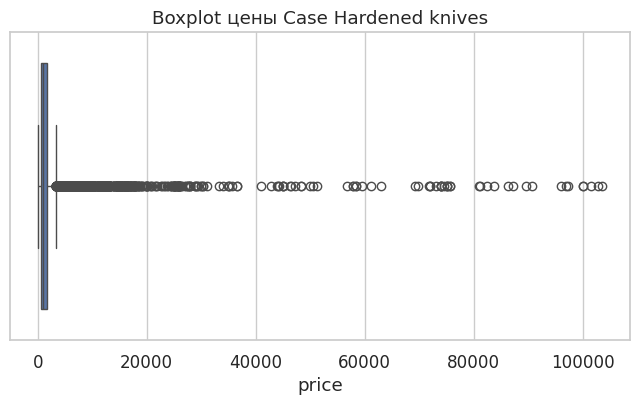

In [4]:


plt.figure(figsize=(8, 4))
sns.histplot(df[TARGET], bins=50, kde=True)
plt.title("Распределение цены Case Hardened knives")
plt.xlabel("price")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x=df[TARGET])
plt.title("Boxplot цены Case Hardened knives")
plt.show()


###  Распределение цен (Histogram + Boxplot)

Цены имеют выраженное правостороннее распределение: основная масса ножей стоит в среднем диапазоне, однако присутствуют редкие экземпляры (blue gem), значительно превышающие основную цену. Boxplot показывает большое количество выбросов.

**Почему важно:**

- объясняет высокие значения RMSE;
- подтверждает наличие редких, но дорогих объектов (необходимость устойчивой модели);
- показывает, что целевая переменная не является нормальной → нужны нелинейные модели (CatBoost).


##  Распределение по weapon и wear

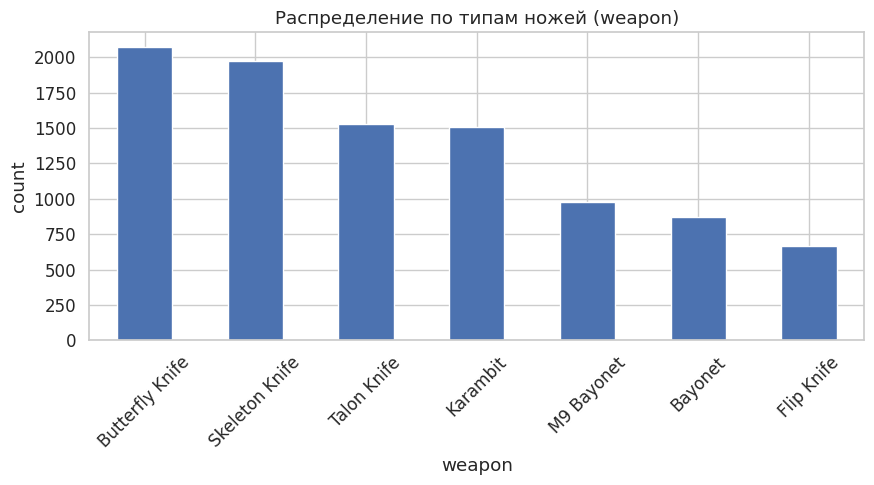

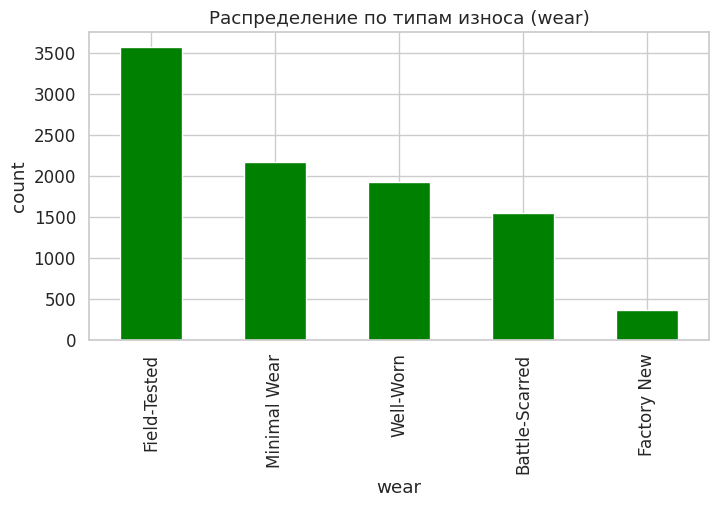

In [5]:


plt.figure(figsize=(10, 4))
df["weapon"].value_counts().plot(kind="bar")
plt.title("Распределение по типам ножей (weapon)")
plt.xlabel("weapon")
plt.ylabel("count")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 4))
df["wear"].value_counts().plot(kind="bar", color="green")
plt.title("Распределение по типам износа (wear)")
plt.xlabel("wear")
plt.ylabel("count")
plt.show()


### Распределение по weapon и wear

Распределение `weapon` показывает, какие модели ножей представлены чаще — на этих данных модель обучится лучше.  
Распределение `wear` демонстрирует, что на рынке доминируют состояния **Field-Tested** и **Minimal Wear**, тогда как **Factory New** встречается реже.

**Почему важно:**

- дисбаланс категорий напрямую влияет на качество модели;
- редкие категории (редкие ножи / редкий износ) могут давать более высокие ошибки.


##  Распределение playside/backside цветов

<Figure size 1000x600 with 0 Axes>

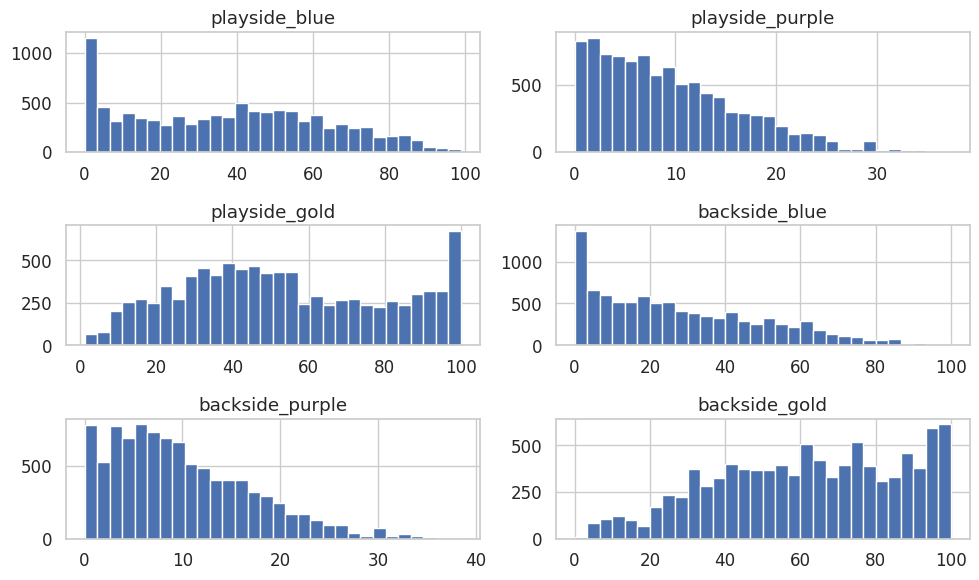

In [6]:

color_cols = [
    "playside_blue", "playside_purple", "playside_gold",
    "backside_blue", "backside_purple", "backside_gold"
]

plt.figure(figsize=(10, 6))
df[color_cols].hist(bins=30, figsize=(10, 6))
plt.tight_layout()
plt.show()


###  Распределение playside/backside цветов

Гистограммы показывают, что большинство ножей имеют низкие значения `playside_blue`, «голубые» паттерны встречаются редко, а высокие уровни синего (> 60%) — крайне редки.

**Почему важно:**

- синий цвет на playside — главный фактор ценообразования для Case Hardened;
- редкость значений объясняет повышенную сложность предсказания Blue Gem ножей;
- подтверждает правильность добавления engineered-фичей (`blue_score`, `pattern_style`, `blue_tier`).



##  Корреляционная матрица

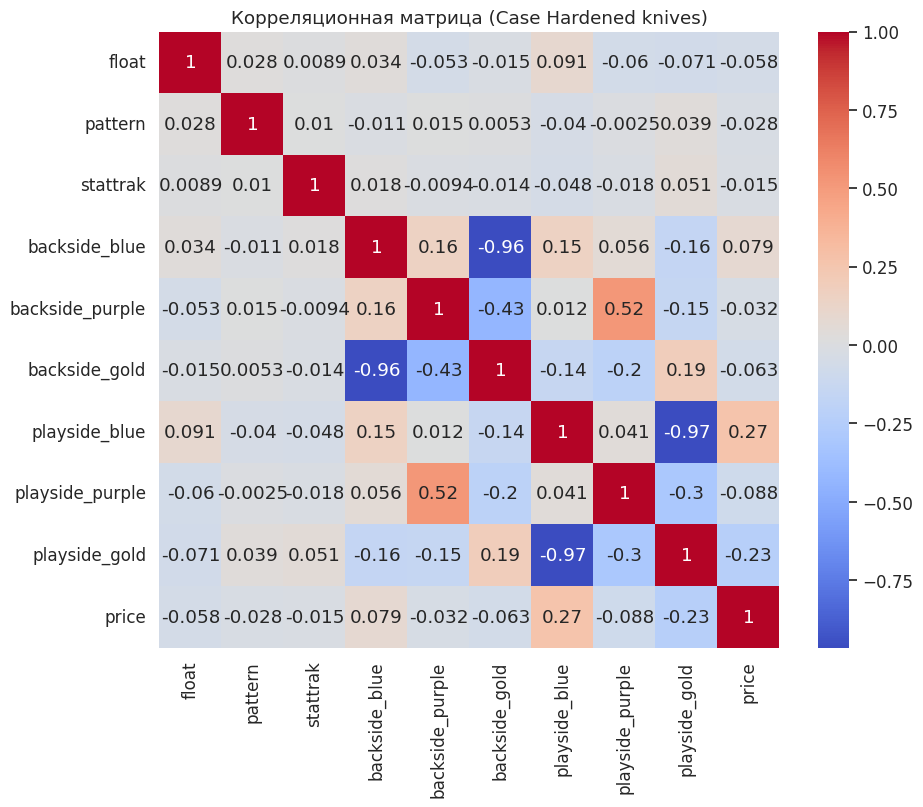

In [7]:


numeric_cols = NUM_FEATURES + [TARGET]

plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Корреляционная матрица (Case Hardened knives)")
plt.show()


### Корреляционная матрица

Матрица показывает слабую линейную связь между `float`, `pattern` и `price`, но более сильную связь между `playside_blue` и `price`.

**Почему важно:**

- подтверждает, что модель должна уметь работать с нелинейными зависимостями;
- обосновывает выбор CatBoost как основного алгоритма;
- указывает на высокую значимость цветовых признаков по сравнению с float и pattern.



##  Влияние float на цену

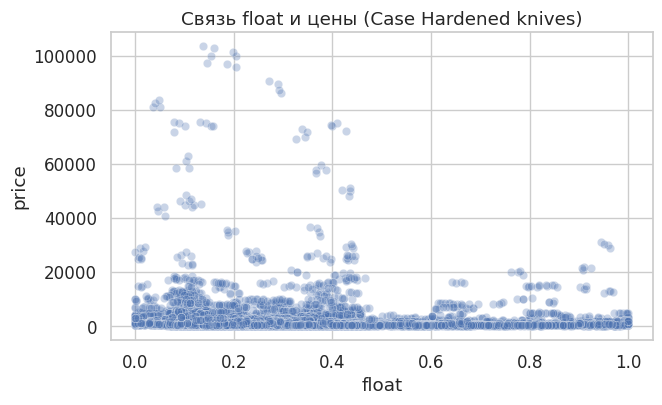

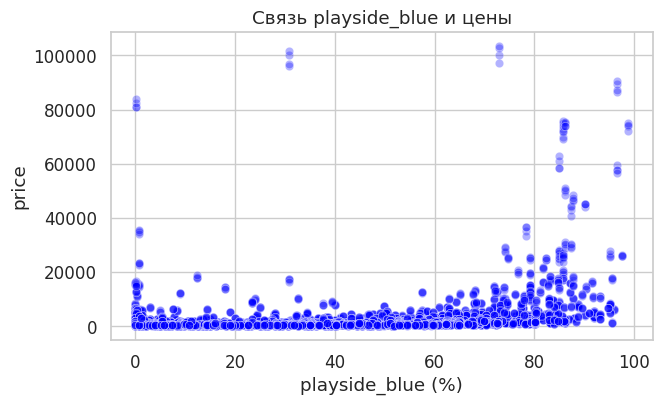

In [8]:


plt.figure(figsize=(7, 4))
sns.scatterplot(x="float", y=TARGET, data=df, alpha=0.3)
plt.title("Связь float и цены (Case Hardened knives)")
plt.xlabel("float")
plt.ylabel("price")
plt.show()

plt.figure(figsize=(7, 4))
sns.scatterplot(x="playside_blue", y=TARGET, data=df, alpha=0.3, color="blue")
plt.title("Связь playside_blue и цены")
plt.xlabel("playside_blue (%)")
plt.ylabel("price")
plt.show()


###  Влияние float на цену

График демонстрирует, что `float` имеет сравнительно небольшой эффект: цена почти не зависит от степени износа для Case Hardened ножей, в отличие от других серий скинов.

**Почему важно:**

- `float` не является доминирующим фактором для данной группы предметов;
- нельзя полагаться только на линейные зависимости между износом и ценой;
- модель должна учитывать более сложные признаки (цвет, тип ножа, редкость паттерна).


##Влияние StatTrak на цену

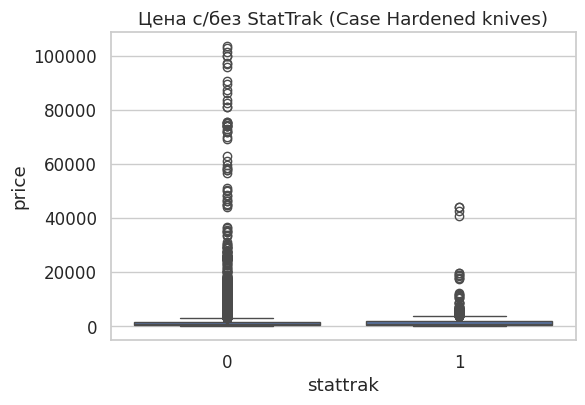

In [11]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="stattrak", y=TARGET, data=df)
plt.title("Цена с/без StatTrak (Case Hardened knives)")
plt.xlabel("stattrak")
plt.ylabel("price")
plt.show()

### StatTrak → price

Boxplot показывает умеренное увеличение медианной цены для предметов со `stattrak = 1`, хотя разброс внутри классов остаётся высоким.

**Почему важно:**

- StatTrak — дополнительный, но не основной фактор ценообразования;
- модель должна учитывать бинарный эффект StatTrak, но не переоценивать его вклад.


#ML

##Разбиение на train / test (80 / 20)

In [12]:

X = df[ALL_FEATURES].copy()
y = df[TARGET].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

cat_indices = [X.columns.get_loc(c) for c in CAT_FEATURES]

train_pool = Pool(X_train, y_train, cat_features=cat_indices)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_indices)

# Для CatBoost будем использовать eval_set=test_pool (как в твоём старом варианте)
val_pool = test_pool


Train: 7676, Test: 1920


##Baseline CatBoost

In [13]:

baseline_model = CatBoostRegressor(
    loss_function="RMSE",
    eval_metric="RMSE",
    depth=8,
    learning_rate=0.05,
    iterations=1500,
    random_seed=RANDOM_STATE,
    od_type="Iter",
    od_wait=120,
    verbose=False
)

baseline_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred_base = baseline_model.predict(test_pool)
mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = math.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)

print("\n=== Baseline CatBoost (Case Hardened knives) ===")
print(f"MAE:  {mae_base:.2f} $")
print(f"RMSE: {rmse_base:.2f} $")
print(f"R²:   {r2_base:.4f}")



=== Baseline CatBoost (Case Hardened knives) ===
MAE:  335.90 $
RMSE: 816.42 $
R²:   0.9841


##Optuna HPO для CatBoost

In [14]:

def objective(trial):
    params = {
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "iterations": trial.suggest_int("iterations", 400, 2000),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "random_seed": RANDOM_STATE,
        "od_type": "Iter",
        "od_wait": 100,
        "verbose": False,
    }
    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, use_best_model=True)
    y_val_pred = model.predict(test_pool)
    rmse_val = math.sqrt(mean_squared_error(y_test, y_val_pred))
    return rmse_val

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("\n=== Optuna Results (Case Hardened knives) ===")
print("Best params:", study.best_params)
print("Best RMSE (test proxy):", study.best_value)

best_params = study.best_params
best_params.update({
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": RANDOM_STATE,
    "od_type": "Iter",
    "od_wait": 100,
    "verbose": False,
})

tuned_model = CatBoostRegressor(**best_params)
tuned_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred_tuned = tuned_model.predict(test_pool)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = math.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\n=== Tuned CatBoost (Case Hardened knives) ===")
print(f"MAE:  {mae_tuned:.2f} $")
print(f"RMSE: {rmse_tuned:.2f} $")
print(f"R²:   {r2_tuned:.4f}")


[I 2025-12-03 02:34:50,649] A new study created in memory with name: no-name-e0caa503-0bd0-492b-8638-ecc6b6a09abb
[I 2025-12-03 02:34:54,815] Trial 0 finished with value: 3272.1270199425667 and parameters: {'depth': 4, 'learning_rate': 0.015901085228635425, 'iterations': 639, 'l2_leaf_reg': 0.7821300466074004}. Best is trial 0 with value: 3272.1270199425667.
[I 2025-12-03 02:35:36,101] Trial 1 finished with value: 1276.3244626302906 and parameters: {'depth': 9, 'learning_rate': 0.01275017843544023, 'iterations': 1229, 'l2_leaf_reg': 1.1553898699956653}. Best is trial 1 with value: 1276.3244626302906.
[I 2025-12-03 02:36:28,309] Trial 2 finished with value: 684.0981054813184 and parameters: {'depth': 9, 'learning_rate': 0.03566298626395513, 'iterations': 1205, 'l2_leaf_reg': 0.4603053879903523}. Best is trial 2 with value: 684.0981054813184.
[I 2025-12-03 02:36:44,775] Trial 3 finished with value: 1582.455538566763 and parameters: {'depth': 8, 'learning_rate': 0.03589554201437991, 'iter


=== Optuna Results (Case Hardened knives) ===
Best params: {'depth': 10, 'learning_rate': 0.07587067282847938, 'iterations': 1385, 'l2_leaf_reg': 0.10833755107429707}
Best RMSE (test proxy): 564.4556885360212

=== Tuned CatBoost (Case Hardened knives) ===
MAE:  178.98 $
RMSE: 564.46 $
R²:   0.9924


##Linear Regression + OneHot

In [15]:

numeric_features = NUM_FEATURES
categorical_features = CAT_FEATURES

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

linreg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])

linreg_model.fit(X_train, y_train)
y_pred_lr = linreg_model.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = math.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("\n=== Linear Regression + OneHot (Case Hardened knives) ===")
print(f"MAE:  {mae_lr:.2f} $")
print(f"RMSE: {rmse_lr:.2f} $")
print(f"R²:   {r2_lr:.4f}")



=== Linear Regression + OneHot (Case Hardened knives) ===
MAE:  2189.06 $
RMSE: 6062.03 $
R²:   0.1214


##Сравнение моделей

In [16]:


results_df = pd.DataFrame([
    {"model": "CatBoost Baseline", "MAE": mae_base, "RMSE": rmse_base, "R2": r2_base},
    {"model": "CatBoost Tuned",    "MAE": mae_tuned, "RMSE": rmse_tuned, "R2": r2_tuned},
    {"model": "Linear Regression", "MAE": mae_lr, "RMSE": rmse_lr, "R2": r2_lr},
])

print("\n=== Сравнение моделей (Case Hardened knives) ===")
display(results_df)



=== Сравнение моделей (Case Hardened knives) ===


,model,MAE,RMSE,R2
0,CatBoost Baseline,335.899404,816.424467,0.984064
1,CatBoost Tuned,178.984588,564.455689,0.992383
2,Linear Regression,2189.055794,6062.032946,0.121410


##Learning curves + Feature importance + SHAP

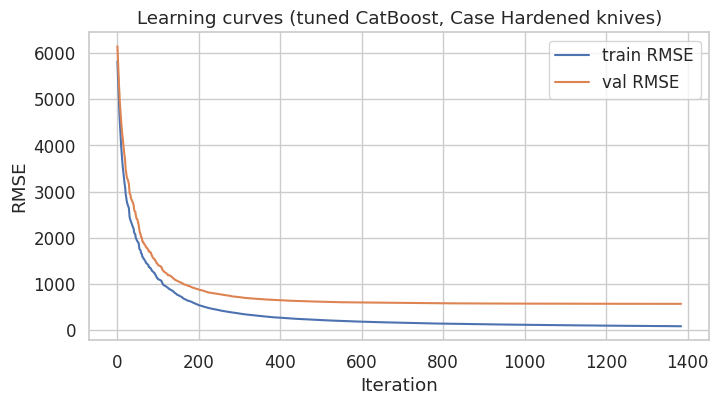


=== ТОП признаков (tuned CatBoost, Case Hardened knives) ===


,feature,importance
6,playside_blue,17.813700
0,float,16.397563
9,weapon,13.227778
7,playside_purple,11.728654
4,backside_purple,7.872006
11,wear,7.549303
8,playside_gold,7.249686
1,pattern,7.127909
5,backside_gold,6.817936
3,backside_blue,4.072014


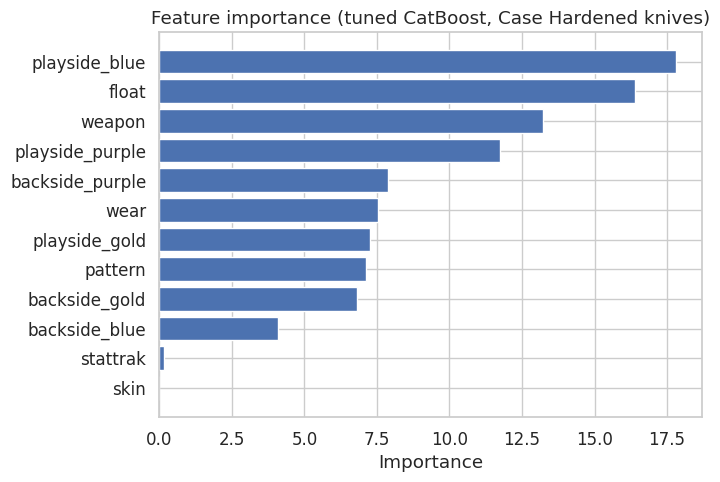

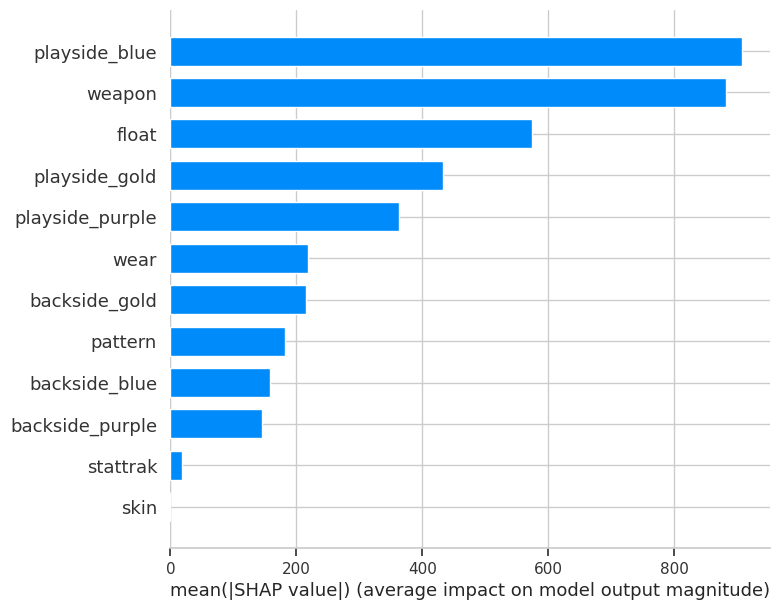

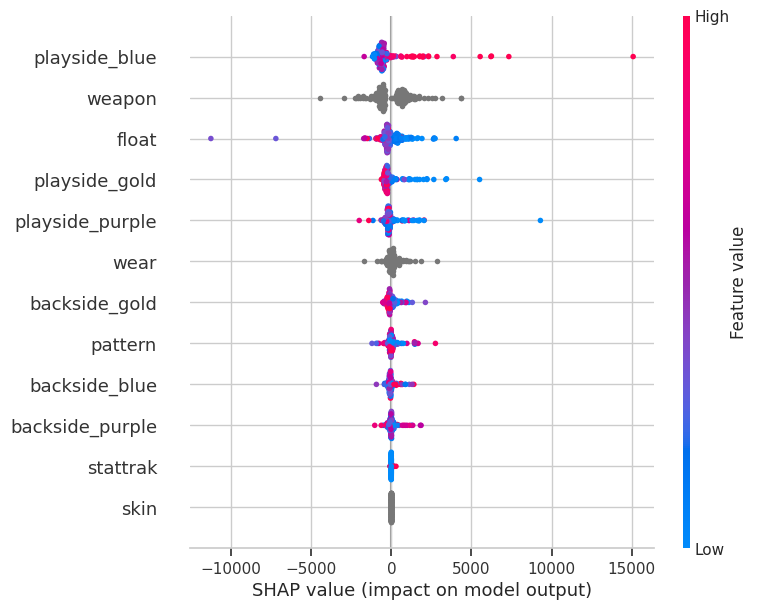

In [17]:
# Learning curves (tuned CatBoost)

evals_result = tuned_model.get_evals_result()
train_rmse = evals_result["learn"]["RMSE"]
val_rmse = evals_result["validation"]["RMSE"]

plt.figure(figsize=(8, 4))
plt.plot(train_rmse, label="train RMSE")
plt.plot(val_rmse, label="val RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Learning curves (tuned CatBoost, Case Hardened knives)")
plt.legend()
plt.show()

#  Feature importance

feat_importances = tuned_model.get_feature_importance(train_pool)
importances_df = pd.DataFrame({
    "feature": X.columns,
    "importance": feat_importances
}).sort_values("importance", ascending=False)

print("\n=== ТОП признаков (tuned CatBoost, Case Hardened knives) ===")
display(importances_df)

plt.figure(figsize=(7, 5))
plt.barh(importances_df["feature"], importances_df["importance"])
plt.gca().invert_yaxis()
plt.title("Feature importance (tuned CatBoost, Case Hardened knives)")
plt.xlabel("Importance")
plt.show()

#  SHAP summary

explainer = shap.TreeExplainer(tuned_model)
X_sample = X_test.sample(min(200, len(X_test)), random_state=RANDOM_STATE)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar")
plt.show()

shap.summary_plot(shap_values, X_sample)
plt.show()


##Оптимизация инференса (Fast модель + замер скорости)

In [18]:

def measure_inference_time(model, X, n_runs=5):
    times = []
    for _ in range(n_runs):
        start = time.time()
        _ = model.predict(X)
        end = time.time()
        times.append(end - start)
    return sum(times) / len(times)

time_base = measure_inference_time(baseline_model, X_test)
time_tuned = measure_inference_time(tuned_model, X_test)
time_lr = measure_inference_time(linreg_model, X_test)

print("=== Время инференса (секунд на весь X_test) ===")
print(f"CatBoost Baseline: {time_base:.4f} s")
print(f"CatBoost Tuned:    {time_tuned:.4f} s")
print(f"Linear Regression: {time_lr:.4f} s")

fast_model = CatBoostRegressor(
    depth=6,
    learning_rate=0.1,
    iterations=400,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=RANDOM_STATE,
    od_type="Iter",
    od_wait=50,
    verbose=False,
)

fast_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred_fast = fast_model.predict(test_pool)
mae_fast = mean_absolute_error(y_test, y_pred_fast)
rmse_fast = math.sqrt(mean_squared_error(y_test, y_pred_fast))
r2_fast = r2_score(y_test, y_pred_fast)
time_fast = measure_inference_time(fast_model, X_test)

print("\n=== Fast CatBoost (Case Hardened knives) ===")
print(f"MAE:  {mae_fast:.2f} $")
print(f"RMSE: {rmse_fast:.2f} $")
print(f"R²:   {r2_fast:.4f}")
print(f"Inference time: {time_fast:.4f} s")

speed_results = pd.DataFrame([
    {"model": "CatBoost Baseline", "MAE": mae_base, "RMSE": rmse_base, "R2": r2_base, "time_s": time_base},
    {"model": "CatBoost Tuned",    "MAE": mae_tuned, "RMSE": rmse_tuned, "R2": r2_tuned, "time_s": time_tuned},
    {"model": "CatBoost Fast",     "MAE": mae_fast, "RMSE": rmse_fast, "R2": r2_fast, "time_s": time_fast},
    {"model": "Linear Regression", "MAE": mae_lr, "RMSE": rmse_lr, "R2": r2_lr, "time_s": time_lr},
])

print("\n=== Качество vs скорость (Case Hardened knives) ===")
display(speed_results)


=== Время инференса (секунд на весь X_test) ===
CatBoost Baseline: 0.0100 s
CatBoost Tuned:    0.0250 s
Linear Regression: 0.0060 s

=== Fast CatBoost (Case Hardened knives) ===
MAE:  601.26 $
RMSE: 1360.64 $
R²:   0.9557
Inference time: 0.0047 s

=== Качество vs скорость (Case Hardened knives) ===


,model,MAE,RMSE,R2,time_s
0,CatBoost Baseline,335.899404,816.424467,0.984064,0.010037
1,CatBoost Tuned,178.984588,564.455689,0.992383,0.025003
2,CatBoost Fast,601.259813,1360.638215,0.955738,0.004715
3,Linear Regression,2189.055794,6062.032946,0.121410,0.005968


# Логирование экспериментов в Weights & Biases

In [21]:

wandb.login()  # при первом запуске попросит API key

def train_and_log_catboost_ch(run_name: str, params: dict, log_shap: bool = False):
    """
    Обучает CatBoost на CH-ножах и логирует эксперимент в W&B:
    - гиперпараметры,
    - метрики MAE, RMSE, R2,
    - learning curves,
    - feature importance,
    - SHAP-графики (если log_shap=True).
    """
    with wandb.init(
        project="cs2-ch-knife-pricing",   # <-- нужное название проекта
        name=run_name,
        config=params
    ):
        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, use_best_model=True, verbose=False)

        # Метрики
        y_pred = model.predict(test_pool)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        wandb.log({"MAE": mae, "RMSE": rmse, "R2": r2})

        # Кривые обучения
        evals_result = model.get_evals_result()
        train_rmse = evals_result["learn"]["RMSE"]
        val_rmse = evals_result["validation"]["RMSE"]

        for step, (tr, va) in enumerate(zip(train_rmse, val_rmse), start=1):
            wandb.log({"RMSE/train": tr, "RMSE/val": va}, step=step)

        # Feature importance
        feat_importances = model.get_feature_importance(train_pool)
        importances_df = pd.DataFrame({
            "feature": X.columns,
            "importance": feat_importances
        }).sort_values("importance", ascending=False)

        plt.figure(figsize=(7, 5))
        plt.barh(importances_df["feature"], importances_df["importance"])
        plt.gca().invert_yaxis()
        plt.title(f"Feature Importance ({run_name})")
        plt.xlabel("Importance")
        wandb.log({"Feature Importance": wandb.Image(plt)})
        plt.close()

        # SHAP-графики (только для tuned-модели)
        if log_shap:
            X_sample = X_test.sample(min(200, len(X_test)), random_state=RANDOM_STATE)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_sample)

            shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
            wandb.log({f"SHAP Summary (bar) [{run_name}]": wandb.Image(plt)})
            plt.close()

            shap.summary_plot(shap_values, X_sample, show=False)
            wandb.log({f"SHAP Summary [{run_name}]": wandb.Image(plt)})
            plt.close()

        return model


def train_and_log_linreg_ch(run_name: str):
    """
    Линейная регрессия (OHE) + логирование метрик в W&B.
    """
    preprocess = ColumnTransformer(
        transformers=[
            ("num", "passthrough", NUM_FEATURES),
            ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_FEATURES),
        ]
    )

    model = Pipeline(steps=[
        ("preprocess", preprocess),
        ("regressor", LinearRegression())
    ])

    with wandb.init(
        project="cs2-ch-knife-pricing",   # <-- одинаковое имя проекта
        name=run_name,
        config={
            "model_type": "LinearRegression",
            "numeric_features": NUM_FEATURES,
            "categorical_features": CAT_FEATURES,
        }
    ):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        wandb.log({"MAE": mae, "RMSE": rmse, "R2": r2})

    return model


# baseline и tuned параметры
baseline_params = {
    "depth": 8,
    "learning_rate": 0.05,
    "iterations": 1500,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": RANDOM_STATE,
    "od_type": "Iter",
    "od_wait": 120,
    "verbose": False,
}

tuned_params = best_params.copy()
tuned_params.update({
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": RANDOM_STATE,
    "od_type": "Iter",
    "od_wait": 100,
    "verbose": False,
})

# Запуск трёх run'ов
cb_base_wb  = train_and_log_catboost_ch("ch_catboost_baseline", baseline_params, log_shap=False)
cb_tuned_wb = train_and_log_catboost_ch("ch_catboost_tuned", tuned_params, log_shap=True)
lr_wb       = train_and_log_linreg_ch("ch_linear_regression")


MAE,▁
R2,▁
RMSE,▁
RMSE/train,██▅▄▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
RMSE/val,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE,335.8994
R2,0.98406
RMSE,816.42447
RMSE/train,352.87774
RMSE/val,816.42443


MAE,▁
R2,▁
RMSE,▁
RMSE/train,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
RMSE/val,█▇▆▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE,178.98459
R2,0.99238
RMSE,564.45569
RMSE/train,78.37909
RMSE/val,564.59434


MAE,▁
R2,▁
RMSE,▁
MAE,2189.05579
R2,0.12141
RMSE,6062.03295
